# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


In [3]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [4]:
def cm2inch(value):
    return value/2.54

# Figsetup
Using 20200408 Chou's data, unit2.<br>
shortcaption: TLMI and TLPI from a iP-RGC and a LC model<br>
label: PID_PC_LC_1Hz

In [5]:
filename = 'PID_PC_LC_'

# Load Experimental data

In [15]:
Fc_list = [10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

dt = 0.01
cn = 53
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [16]:
# Dt = 0.01
v_list = [np.append(0, np.diff(x))/dt  for x in x_list]
tv_list = [ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list]

In [17]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

In [ ]:
# mdict ={'x': x_list[0],
#         'v': v_list[0],
#         'r': rstate_list[0]}

# savemat('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\test\\test.mat', mdict)

In [18]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

# Fake Spike - LC model

In [24]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
yLC_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for i in range(len(x_list)):
    Lambda = 0.25
    r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]
    yLC_list[i] =  (1-Lambda)*x_list[i]+Lambda*v_list[i] 
    r = NL(r1-np.mean(r1), 0)
    ratio = sum(r)/T_list[i][-1]/20
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))

In [25]:
# plt.plot(r1, 'm')
# plt.axhline(0, c = 'gray', linewidth = 1, alpha = 0.7)
# plt.xlim([13500,14500])
          
# plt.eventplot(FakeSpike_list[0], color ='blueviolet')
# plt.xlim([135,145])
# plt.gcf().set_size_inches(10, 3)

In [26]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

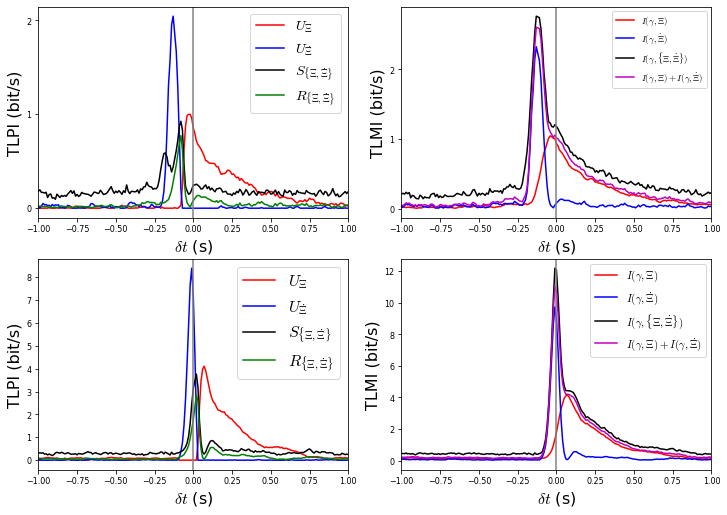

In [27]:
plt.rcParams["font.size"] = 8

for i in range(len(x_list)):
    fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
    Information_list = Real_Information_list
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
    ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
    ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
    ax2.axvline(0, c = 'gray')
    ax2.set_xlim(window)

    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                       +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
    ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
    ax3.axvline(0, c = 'gray')
    ax3.set_xlim(window)
    ax3.legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
               loc='best', prop={'size': 9})

    # --------------------------------------------------------------------------------------------------------------------------------
    Information_list = LC_Information_list
    ax4.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax4.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax4.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax4.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax4.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax4.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
    ax4.set_ylabel('TLPI (bit/s)', fontsize = 16)
    ax4.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 16})
    ax4.axvline(0, c = 'gray')
    ax4.set_xlim(window)

    ax5.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax5.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax5.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                       +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax5.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax5.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax5.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
    ax5.set_ylabel('TLMI (bit/s)', fontsize = 16)
    ax5.axvline(0, c = 'gray')
    ax5.set_xlim(window)
    ax5.legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
               loc='best', prop={'size': 11})

    # fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
    fig.set_size_inches(10, 7)
    fig.savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\A\\'+filename+str(Fc_list[i]/2)+'Hz_base.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)

In [15]:
# plt.plot(timeshift-0.2,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
# plt.xlabel(r'$\delta t$ (s)', fontsize = 16)
# plt.ylabel(r'$I(\gamma,\xi; \delta t)$ (bit/s)', fontsize = 16)
# plt.axvline(0, c = 'gray')
# plt.xlim([-0.8, 0.8])

# plt.gcf().savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\M\\TLMIintro_base.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)